# **Reinforcement Learning algorithm**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2043.39210. ~
- DescriptionAutonomous self-driving car using DQN algorithm in CARLA environmen---

## **Abstract***
-




## **1. Environment Details**

강화학습에 사용될 환경을 정의합니다.

### **1-1. Set Parameters**

강화학습 과정에서 사용되는 파라미터를 정의합니다. 파라미터는 다음과 같습니다.

- SHOW_PYGAME_DISPLAY:\
  ㅇㅇㅇ
- TARGET_SPEED:\
  차량의 목표 속도입니다.
- MAX_ITER:\
  
- START_BUFFER

In [1]:
SHOW_PYGAME_DISPLAY = False

# 차량의 목표 속도
TARGET_SPEED = 40
# 최대 
MAX_ITER = 4000
# 시작 버퍼 크기
START_BUFFER = 10
# 학습 빈도
TRAIN_FREQ = 2
# 저장 빈도
SAVE_FREQ = 100
# 시작 에피소드
START_EP = 0

MAX_DIST_FROM_WAYPOINT = 20



### **1-2. Create CARLA Environment**

CARLA 환경을 구축합니다.
CARLA 환경을 구축하는 과정은 다음과 같습니다.

#### 1. CARLA 환경 초기화
1-1. CARLA 클라이언트 연결
1-2. 월드 데이터 받아오

In [2]:
class CarEnv():
    def __init__(self) -> None:
        if SHOW_PYGAME_DISPLAY:
            self.display = PyGameDisplay()
        
        # Connect CARLA client
        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(10)

        # Get world data
        self.world = self.client.load_world(params["map"])
        self.world.unload_map_layer(carla.MapLayer.Decals)
        self.world.unload_map_layer(carla.MapLayer.Foliage)
        self.world.unload_map_layer(carla.MapLayer.ParkedVehicles)
        self.world.unload_map_layer(carla.MapLayer.Particles)
        self.world.unload_map_layer(carla.MapLayer.Props)
        self.world.unload_map_layer(carla.MapLayer.StreetLights)

        # Get map from world
        self.map = self.world.get_map()

        # Get blueprint library
        self.blueprint_library = self.world.get_blueprint_library()

        # reset actor list
        self.vehicle_list = []

        # Environment Init
        self.reset()
        
        # input these later on as arguments
        self.global_t = 0 # global timestep
        self.start_train = START_EP + START_BUFFER
        
        self.total_rewards = 0
        self.average_rewards_list = []
        self.ep_reward_list = []

    def reset(self):
        # reset actor list
        for vehicle in self.vehicle_list:
            vehicle.destroy()

        self.vehicle_list = []
        
        # Create Waypoints
        self.waypoint = Waypoint(self)

        # Create vehicle actor
        self.vehicle = Vehicle(self, self.waypoint)
        self.vehicle_list.append(self.vehicle)

        # Reset global timestep
        self.g_time = 0

    def step(self, model, replay_memory, ep, action_map, eval=False):
        with CarlaSyncMode(self.world, self.vehicle.rgb_cam, self.vehicle.observe_cam, self.vehicle.collision_sensor, fps=30) as sync_mode:
            # Initialize agent step count
            step_count = 0
            ep_reward = 0

            # Get state from world
            snapshot, image_rgb, image_observe, collision = sync_mode.tick(timeout=2.0)
            
            # destroy if there is no data
            if snapshot is None or image_rgb is None:
                print("No data, skipping episode")
                self.reset()
                return None

            image = self.vehicle.process_img(image_rgb)
            next_state = image 

            while True:
                # Get vehicle state
                vehicle_location = self.vehicle.get_location()
                waypoint = self.world.get_map().get_waypoint(vehicle_location, project_to_road=True, lane_type=carla.LaneType.Driving)
                speed = self.vehicle.get_speed()

                # Render waypoint every 10 step count
                if step_count % 10 == 0:
                    #self.waypoint.render()
                    self.world.debug.draw_string(
                        waypoint.transform.location, 
                        'O', 
                        draw_shadow=False,
                        color=carla.Color(r=255, g=0, b=0), 
                        life_time=0.2,
                        persistent_lines=True
                )

                # Advance the simulation and wait for the data.
                state = next_state

                step_count += 1
                self.g_time += 1

                action = model.select_action(state, eval=eval)
                steer = action
                if action_map is not None:
                    steer = action_map[action]

                # Select action based on state(rgb camera)
                self.vehicle.apply_control(steer)

                fps = round(1.0 / snapshot.timestamp.delta_seconds)

                snapshot, image_rgb, image_observe, collision = sync_mode.tick(timeout=2.0)

                reward, collision = get_reward_comp(self.vehicle, waypoint, collision)

                if snapshot is None or image_rgb is None:
                    print("Process ended here")
                    break

                image = self.vehicle.process_img(image_rgb)

                done = 1 if collision else 0

                self.total_rewards += reward
                ep_reward += reward

                next_state = image

                replay_memory.add(state, action, next_state, reward, done)

                if not eval:
                    if ep > self.start_train and (self.g_time % TRAIN_FREQ) == 0:
                        model.train(replay_memory)

                # Draw the display.
                if SHOW_PYGAME_DISPLAY:
                    self.render(image_observe, fps)

                if collision == 1 or step_count >= 1000:
                    self.ep_reward_list.append(ep_reward)
                    print("Episode {:4d} processed {:5d} | reward: {}".format(ep, step_count, ep_reward))
                    break
            
            if ep % SAVE_FREQ == 0 and ep > 0:
                self.save(model, ep)

    def render(self, image_observe, fps):
        draw_image(self.pg_display.display, image_observe)
        self.pg_display.display.blit(
            self.pg_display.font.render('% 5d FPS (real)' % self.pg_display.clock.get_fps(), True, (255, 255, 255)),
            (8, 10)
        )
        self.pg_display.display.blit(
            self.pg_display.font.render('% 5d FPS (simulated)' % fps, True, (255, 255, 255)),
            (8, 28)
        )
        pygame.display.flip()

    def save(self, model, ep):
        if ep % SAVE_FREQ == 0 and ep > START_EP:
            avg_reward = self.total_rewards/ep
            self.average_rewards_list.append(avg_reward)
            self.total_rewards = 0

            model.save("../weights/model_ep_{}".format(ep))

            print("Saved model with average reward =", avg_reward)

    def show_reward_graph(self):
        plt.subplots(figsize=(10, 7))
        sns.lineplot(self.ep_reward_list, label="ep-reward")
        
    def close(self):
        print("=== END ===")
        # pygame.quit()

## **Load libraries**
Import carla module and PyTorch.

In [3]:
# Add file path
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

import random
import numpy as np
from collections import namedtuple, deque
import cv2
import math
import copy
import pygame
import seaborn as sns
import matplotlib.pyplot as plt

# Import CARLA modules
import carla
from src.agents.navigation.controller import PIDLongitudinalController
from src.agents.navigation.global_route_planner import GlobalRoutePlanner
from src.synchronous_mode import CarlaSyncMode

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pygame 2.5.2 (SDL 2.28.3, Python 3.8.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


## **Setting parameter(map, vehicle, etc)**

In [4]:
params = {
    "map": "Town04_Opt",
    "vehicle": "vehicle.mini.cooper_s_2021"
}

## **Make carla environment**

CARLA 환경에 관한 클래스를 선언합니다.

CARLA 환경은 크게 4단계로 구성되어 있습니다.

### **Key Steps:**
#### **1. __init__()**
- CARLA 환경을 초기화합니다. 여기에는 CARLA Client 연결, 맵 로드, Blueprint library 받아오기 등의 작업이 있습니다.

#### **2. reset()**
- CARLA 환경의 상태를 모두 초기화합니다.

#### **3. step()**
- 

In [5]:
class Vehicle():
    def __init__(self, env, waypoint):
        # Initialize actor list
        self.actor_list = []
        
        # Set vehicle spawn point
        transform = waypoint.start_point
        self.vehicle_model = env.blueprint_library.filter(params["vehicle"])[0]

        # Spawning the vehicle
        self.vehicle = env.world.spawn_actor(self.vehicle_model, transform)
        self.actor_list.append(self.vehicle)
        
        # Attach Camera with Vehicle
        self.rgb_cam = env.world.spawn_actor(
            env.blueprint_library.find('sensor.camera.rgb'),
            carla.Transform(carla.Location(x=1.5, z=2.4), carla.Rotation(pitch=-15)),
            attach_to=self.vehicle)
        self.actor_list.append(self.rgb_cam)

        # Observer Camera
        self.observe_cam = env.world.spawn_actor(
            env.blueprint_library.find('sensor.camera.rgb'),
            carla.Transform(carla.Location(x=-1.5, z=17.8), carla.Rotation(pitch=-90)),
            attach_to=self.vehicle)
        self.actor_list.append(self.observe_cam)
        
        # Attach Collision Sensor with Vehicle
        self.collision_sensor = env.world.spawn_actor(
            env.blueprint_library.find('sensor.other.collision'),
            carla.Transform(),
            attach_to=self.vehicle
        )
        self.actor_list.append(self.collision_sensor)

        self.speed_controller = PIDLongitudinalController(self.vehicle)

        self.target_speed = 30

    def get_location(self):
        return self.vehicle.get_location()

    def get_transform(self):
        return self.vehicle.get_transform()

    def get_speed(self):
        """
        Compute speed of a vehicle in Km/h.
            :param vehicle: the vehicle for which speed is calculated
            :return: speed as a float in Km/h
        """
        vel = self.vehicle.get_velocity()
    
        return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)

    def apply_control(self, steer):
        control = self.speed_controller.run_step(self.target_speed)
        control.steer = steer
        self.vehicle.apply_control(control)

    def process_img(self, image, dim_x=128, dim_y=128):
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        array = array[:, :, :3]
        array = array[:, :, ::-1]
    
        dim = (dim_x, dim_y)  # set same dim for now
        resized_img = cv2.resize(array, dim, interpolation=cv2.INTER_AREA)
        img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        scaledImg = img_gray/255.
    
        # normalize
        mean, std = 0.5, 0.5
        normalizedImg = (scaledImg - mean) / std
    
        return normalizedImg

    def collision_data(self, event):
        lane_types = set(x.type for x in event.crossed_lane_markings)
        text = ['%r' % str(x).split()[-1] for x in lane_types]
        print('Crossed line %s' % ' and '.join(text))

    def destroy(self):
        for actor in self.actor_list:
            actor.destroy()

In [6]:
class Waypoint():
    def __init__(self, env):
        self.env = env
        self.sampling_resolution = 2
        self.grp = GlobalRoutePlanner(env.map, self.sampling_resolution)
        spawn_points = env.map.get_spawn_points()
        
        # self.start_point = random.choice(env.map.get_spawn_points())
        # self.end_point = random.choice(env.map.get_spawn_points())
        # self.start_point_location = carla.Location(self.start_point.location)
        # self.end_point_location = carla.Location(self.end_point.location)
        # self.waypoints = self.grp.trace_route(self.start_point_location, self.end_point_location) # there are other funcations can be used to generate a route in GlobalRoutePlanner.
        
        self.start_point = spawn_points[100]
        self.end_point = spawn_points[100]
        self.start_point_location = carla.Location(self.start_point.location)
        self.end_point_location = carla.Location(self.end_point.location)
        self.waypoints = self.grp.trace_route(self.start_point_location, self.end_point_location)

    def render(self):
        i = 0
        for w in self.waypoints:
            if i % 10 == 0:
                self.env.world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), life_time=0.2,
                persistent_lines=True)
            else:
                self.env.world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                color = carla.Color(r=0, g=0, b=255), life_time=0.2,
                persistent_lines=True)
            i += 1

    def get_next_waypoint(self, vehicle):
        vehicle_location = vehicle.get_location()
        min_distance = 1000
        next_waypoint = None

        for waypoint in self.waypoints:
            waypoint_location = waypoint.transform.location

            #Only check waypoints that are in the front of the vehicle (if x is negative, then the waypoint is to the rear)
            #TODO: Check if this applies for all maps
            if (waypoint_location - vehicle_location).x > 0:
    
                #Find the waypoint closest to the vehicle, but once vehicle is close to upcoming waypoint, search for next one
                if vehicle_location.distance(waypoint_location) < min_distance and vehicle_location.distance(waypoint_location) > 5:
                    min_distance = vehicle_location.distance(waypoint_location)
                    next_waypoint = waypoint
    
        return next_waypoint

## Create ReplayMemory Class

### 재현 메모리(Replay Memory)


In [7]:
class ReplayMemory(object):
    def __init__(self, state_dim, batch_size, buffer_size, device):
        self.batch_size = batch_size
        self.max_size = int(buffer_size)
        self.device = device

        self.ptr = 0
        self.crt_size = 0

        self.state = np.zeros((self.max_size,) + state_dim)
        self.action = np.zeros((self.max_size, 1))
        self.next_state = np.array(self.state)
        self.reward = np.zeros((self.max_size, 1))
        self.done = np.zeros((self.max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self):
        ind = np.random.randint(0, self.crt_size, size=self.batch_size)
        return (
            torch.FloatTensor(self.state[ind]).unsqueeze(1).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).unsqueeze(1).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.done[ind]).to(self.device)
        )

In [8]:
class ConvNet(nn.Module):
    def __init__(self, dim, in_channels, num_actions) -> None:
        super(ConvNet, self).__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_layer1 = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.fc_layer3 = nn.Sequential(
            nn.Linear(32, num_actions),
            nn.Sigmoid()
        )
        
        self.conv1 = nn.Conv2d(in_channels, 32, 8, 4)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 32)
        self.fc2_bn = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, num_actions)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = self.cnn_layer3(x)
        x = self.flatten(x)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        return x
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.fc1_bn(self.fc1(x.reshape(-1, 64*8*8))))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [9]:
class DQNAgent(object):
    def __init__(
        self,
        num_actions,
        state_dim, #?
        in_channels,
        device,
        discount=0.9,
        optimizer="Adam",
        optimizer_parameters={'lr':0.01},
        target_update_frequency=1e4,
        initial_eps = 1,
        end_eps = 0.05,
        eps_decay_period = 25e4,
        eval_eps=0.001
    ) -> None:
        # Set Device
        self.device = device

        self.Q = ConvNet(state_dim, in_channels, num_actions).to(self.device)
        self.Q_target = copy.deepcopy(self.Q)  # copy target network
        self.Q_optimizer = getattr(torch.optim, optimizer)(self.Q.parameters(), 
        **optimizer_parameters)

        self.discount = discount

        self.target_update_frequency = target_update_frequency
 
        # epsilon decay
        self.initial_eps = initial_eps
        self.end_eps = end_eps
        self.slope = (self.end_eps - self.initial_eps) / eps_decay_period

        self.state_shape = (-1,) + state_dim
        self.eval_eps = eval_eps
        self.num_actions = num_actions

        self.iterations = 0

    def select_action(self, state, eval=False):
        eps = self.eval_eps if eval else max(self.slope * self.iterations + self.initial_eps, self.end_eps)
        self.current_eps = eps

        # Select action according to policy with probability (1-eps)
        # otherwise, select random action
        if np.random.uniform(0,1) > eps:
            self.Q.eval()
            with torch.no_grad():
                # without batch norm, remove the unsqueeze
                state = torch.FloatTensor(state).reshape(self.state_shape).unsqueeze(0).to(self.device)
                return int(self.Q(state).argmax(1))
        else:
            return np.random.randint(self.num_actions)


    def train(self, replay_memory):
        self.Q.train()
        # Sample mininbatch from replay buffer
        state, action, next_state, reward, done = replay_memory.sample()

        # Convert action tensor to int64 data type
        action = action.clone().detach().long()

        # Compute the target Q value
        with torch.no_grad():
            target_Q = reward + (1-done) * self.discount * self.Q_target(next_state).max(1, keepdim=True)[0]

        # Get current Q estimate
        # torch gather just selects action values from Q(state) using the action tensor as an index
        current_Q = self.Q(state).gather(1, action)

        # Compute Q loss
        Q_loss = F.smooth_l1_loss(current_Q, target_Q)

        # Optimize the Q
        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        self.Q_optimizer.step()

        # Update target network by full copy every X iterations.
        self.iterations += 1
        self.copy_target_update()
    
    def copy_target_update(self):
        if self.iterations % self.target_update_frequency == 0:
            print('target network updated')
            print('current epsilon', self.current_eps)
            self.Q_target.load_state_dict(self.Q.state_dict())


    def save(self, filename):
        torch.save(self.Q.state_dict(), filename + "_Q")
        torch.save(self.Q_optimizer.state_dict(), filename + "_optimizer")


    def load(self, filename):
        self.Q.load_state_dict(torch.load(filename + "_Q"))
        self.Q_target = copy.deepcopy(self.Q)
        self.Q_optimizer.load_state_dict(torch.load(filename + "_optimizer"))

In [10]:
def get_reward_comp(vehicle, waypoint, collision):
    vehicle_location = vehicle.get_location()
    x_wp = waypoint.transform.location.x
    y_wp = waypoint.transform.location.y

    x_vh = vehicle_location.x
    y_vh = vehicle_location.y

    wp_array = np.array([x_wp, y_wp])
    vh_array = np.array([x_vh, y_vh])

    dist = np.linalg.norm(wp_array - vh_array)

    vh_yaw = correct_yaw(vehicle.get_transform().rotation.yaw)
    wp_yaw = correct_yaw(waypoint.transform.rotation.yaw)
    cos_yaw_diff = np.cos((vh_yaw - wp_yaw)*np.pi/180.)

    collision = 0 if collision is None else 1

    # speed = -1 if vehicle.get_speed() <= 20 else 1

    reward = cos_yaw_diff - dist - (3 * collision) # + (5 * speed)
    
    return reward, collision



def correct_yaw(x):
    return(((x%360) + 360) % 360)

In [11]:
class PyGameDisplay():
    def __init__(self):
        pygame.init()

        self.display = pygame.display.set_mode(
            (800, 600),
            pygame.HWSURFACE | pygame.DOUBLEBUF)
        self.font = self.get_font()
        self.clock = pygame.time.Clock()

    def get_font(self):
        fonts = [x for x in pygame.font.get_fonts()]
        default_font = 'ubuntumono'
        font = default_font if default_font in fonts else fonts[0]
        font = pygame.font.match_font(font)
        return pygame.font.Font(font, 14)
    
    def should_quit(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return True
            elif event.type == pygame.KEYUP:
                if event.key == pygame.K_ESCAPE:
                    return True
        return False

In [12]:
# dqn action values
action_values = [
    -0.75, 
    -0.5, 
    -0.25, 
    -0.15, 
    -0.1, 
    -0.05, 
    0,
    0.05, 
    0.1,
    0.5, 
    0.75
]
action_map = {i:x for i, x in enumerate(action_values)}


Episode    0 processed   199 | reward: 49.22367825989754
Episode    1 processed   145 | reward: 39.498208085744764
Episode    2 processed   168 | reward: 24.02305880355919
Episode    3 processed   193 | reward: 52.851954277607604
Episode    4 processed   223 | reward: 57.183353944448605
Episode    5 processed   142 | reward: 42.51779724889651
Episode    6 processed   204 | reward: 41.65928733754335
Episode    7 processed   169 | reward: 53.49275038857137
Episode    8 processed   152 | reward: 45.36267622674882
Episode    9 processed   159 | reward: 35.31923478467035
Episode   10 processed   182 | reward: 40.09799461280908
Episode   11 processed   179 | reward: 42.268532278367445
Episode   12 processed   180 | reward: 52.550041275444435
Episode   13 processed   152 | reward: 57.96223340851926
Episode   14 processed   262 | reward: 55.24669695662271
Episode   15 processed   161 | reward: 40.76712916768189
Episode   16 processed   175 | reward: 0.3243277233577393
Episode   17 processed   

KeyboardInterrupt: 

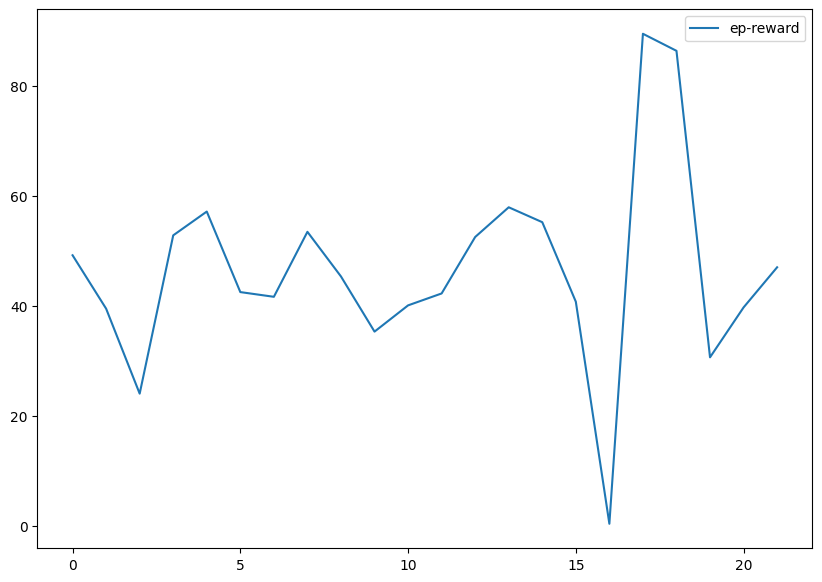

In [13]:
try:
    buffer_size = 1e4
    batch_size = 32
    episodes = 5000
    state_dim = (128, 128)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_actions = len(action_values)
    in_channels = 1
    
    replay_memory = ReplayMemory(state_dim, batch_size, buffer_size, device)
    model = DQNAgent(num_actions, state_dim, in_channels, device)

    # this only works if you have a model in your weights folder. Replace this by that file
    # model.load('../weights/model_ep_1400')

    # set to True if you want to run with pygame
    env = CarEnv()

    for ep in range(episodes):
        env.step(model, replay_memory, ep, action_map)
        env.reset()
finally:
    env.reset()
    env.close()
    env.show_reward_graph()